## Landsat-8 stage-in

### Search parameters

Define the series

In [1]:
series = 'https://catalog.terradue.com/landsat8/search'

Define the area of interest as a lon,lat point and an extent

In [2]:
lon = 68.08586
lat = 37.20143
extent = 0.1

Define the time of interest

In [3]:
start_date = '2016-04-01T00:00:00'
stop_date = '2016-04-10T23:59:59'

### Import the required modules

In [4]:
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")
import os
import sys
import glob
os.environ['_CIOP_APPLICATION_PATH']=''
sys.path.append('/opt/anaconda/bin/')
import cioppy
ciop = cioppy.Cioppy()

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

sys.path.append('/opt/OTB-6.2.0/lib/python')
sys.path.append('/opt/OTB-6.2.0/lib/libfftw3.so.3')
os.environ['OTB_APPLICATION_PATH'] = '/opt/OTB-6.2.0/lib/otb/applications'
os.environ['LD_LIBRARY_PATH'] = '/opt/OTB-6.2.0/lib'
os.environ['ITK_AUTOLOAD_PATH'] = '/opt/OTB-6.2.0/lib/otb/applications'
os.environ['GDAL_DATA'] = '/opt/anaconda/share/gdal/'
import otbApplication

import gc

### Stage-in folder

In [5]:
tmp_dir = '/workspace/data'

In [6]:
if not os.path.isdir(tmp_dir):
    os.makedirs(tmp_dir)

### Build and submit the catalog search

Create a bounding box with the point and the extent

In [7]:
lon_min = lon - extent
lon_max = lon + extent
lat_min = lat - extent
lat_max = lat + extent

Format the bounding box for the catalog search 

In [8]:
bbox = str(lon_min) + '%2C' + str(lat_min) + '%2C' + str(lon_max) + '%2C' + str(lat_max)

In [9]:
opensearch = '%s?bbox=%s&start=%s&stop=%s' % (series, bbox, start_date, stop_date)

Here's the final OpenSearch query

In [10]:
opensearch

'https://catalog.terradue.com/landsat8/search?bbox=67.98586%2C37.10143%2C68.18586%2C37.30143&start=2016-04-01T00:00:00&stop=2016-04-10T23:59:59'

Submit the query to the catalogue

In [11]:
search = ciop.search(end_point = opensearch, params = [], output_fields='enclosure,identifier', model='GeoTime')

In [12]:
for index, elem in enumerate(search):
    print(index, elem['identifier'])

(0, 'LC81530342016095LGN00')


### Stage-in the data

Select the index of the returned results

In [13]:
l8_index = 0

Stage-in the data or if it's already staged-in only set the *retrieved* variable

In [14]:
try:
    retrieved = ciop.copy(search[l8_index]['enclosure'], tmp_dir)
except:
    retrieved = os.path.join(tmp_dir, search[l8_index]['identifier'])

Split into a path and an identifier

In [15]:
data_path = os.path.split(retrieved)[0]
l8_identifier = os.path.split(retrieved)[1]
l8_identifier

'LC81530342016095LGN00'

### Create and plot  the RGB composites

Search for the granule(s) in the Sentinel-2 product

In [16]:
product_path = os.path.join(data_path, l8_identifier)
os.chdir(product_path)

In [17]:
products = [ name for name in os.listdir('.') ]

products

['LC81530342016095LGN00_B1.TIF',
 'LC81530342016095LGN00_B2.TIF',
 'LC81530342016095LGN00_B3.TIF',
 'LC81530342016095LGN00_B4.TIF',
 'LC81530342016095LGN00_B5.TIF',
 'LC81530342016095LGN00_B6.TIF',
 'LC81530342016095LGN00_B7.TIF',
 'LC81530342016095LGN00_B8.TIF',
 'LC81530342016095LGN00_B9.TIF',
 'LC81530342016095LGN00_B10.TIF',
 'LC81530342016095LGN00_B11.TIF',
 'LC81530342016095LGN00_BQA.TIF',
 'LC81530342016095LGN00_MTL.txt']

In [18]:
swir_index = 4
red_index = 3
green_index = 2
blue_index = 1

Create an array with the bands 5, 4, 3 and 2

In [19]:
l8_bands = [products[swir_index], products[red_index], products[green_index], products[blue_index]]

Use OTB to rescale the data to the 0-255 range

In [20]:
results = []

for index, item in enumerate(l8_bands, start = 0):
    print(item)
    app = otbApplication.Registry.CreateApplication("Rescale")
    app.SetParameterString("in", item)
    app.SetParameterFloat("outmin", 0)
    app.SetParameterFloat("outmax", 255)
    app.Execute()
    
    result = app.GetVectorImageAsNumpyArray("out")
    results.append(result.astype(np.uint8))

LC81530342016095LGN00_B5.TIF
LC81530342016095LGN00_B4.TIF
LC81530342016095LGN00_B3.TIF
LC81530342016095LGN00_B2.TIF


Define the composites

In [21]:
img_432 = np.dstack((results[1], results[2], results[3]))
img_543 = np.dstack((results[0], results[1], results[2]))

rgbs = [img_432, img_543]
rgbs_caption = ['Landsat-8 true colour composite', 'Landsat-8 color infrared (vegetation) composite']

Plot the composites

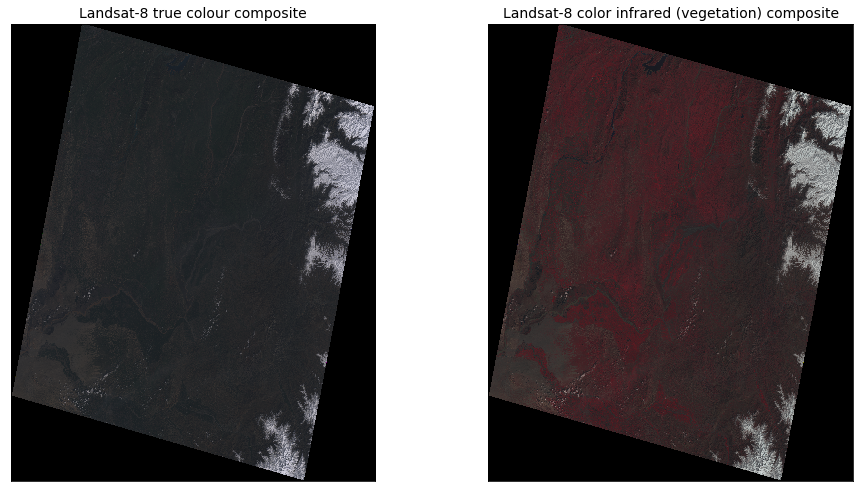

3830

In [22]:
fig = plt.figure(figsize=(20,20)) 
i = 1
for rgb in rgbs:
    ax = fig.add_subplot(330+i) 
    ax.set_title(rgbs_caption[i-1], fontsize=14)
    i = i + 1
    map = Basemap(projection = 'merc',
              llcrnrlat = lat_min,
              urcrnrlat = lat_max,
              llcrnrlon = lon_min,
              urcrnrlon = lon_max,
              resolution='i',
              ax=ax)

    map.imshow(rgb, origin='upper', ax=ax)
    map.drawcountries(color='blue', linewidth=1.5, ax=ax)
    map.drawcoastlines(linewidth=1.5, color='red', ax=ax)

plt.tight_layout()
fig = plt.gcf()
plt.show()
fig.clf()
gc.collect()